In [1]:
import numpy as np
import collections
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')
from utils import load_results
from utils import precision_recall_scores as roc
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'system')

def get_dict_for_method(method, input_dir, chrms, tissue, sb = '0.01'):
    chrmdicts = [dict() for c in chrms]
    datadir = os.path.join(input_dir, tissue)
    print("Reading {:s} for {:s}".format(tissue, method))
    for i, chrm in enumerate(chrms):
        if method == 'tejaas_maf':
            filepath = os.path.join(datadir, 'tejaas', 'mafnull_sb{:s}'.format(sb), 'chr{:d}'.format(chrm), 'rr.txt')
            chrmdicts[i] = load_results.tejaas(filepath)
        elif method == 'tejaas_rand_maf':
            filepath = os.path.join(datadir, 'tejaas_rand', 'mafnull_sb{:s}'.format(sb), 'chr{:d}'.format(chrm), 'rr.txt')
            chrmdicts[i] = load_results.tejaas(filepath)
        elif method == 'tejaas_perm':
            filepath = os.path.join(datadir, 'tejaas', 'permnull_sb{:s}'.format(sb), 'chr{:d}'.format(chrm), 'rr.txt')
            chrmdicts[i] = load_results.tejaas(filepath)
        elif method == 'tejaas_rand_perm':
            filepath = os.path.join(datadir, 'tejaas_rand', 'permnull_sb{:s}'.format(sb), 'chr{:d}'.format(chrm), 'rr.txt')
            chrmdicts[i] = load_results.tejaas(filepath)
        elif method == 'cpma':
            filepath = os.path.join(datadir, 'tejaas', 'jpa', 'chr{:d}'.format(chrm), 'jpa.txt')
            chrmdicts[i] = load_results.jpa(filepath)
        elif method == 'cpma_rand':
            filepath = os.path.join(datadir, 'tejaas_rand', 'jpa', 'chr{:d}'.format(chrm), 'jpa.txt')
            chrmdicts[i] = load_results.jpa(filepath)
        elif method == 'matrixeqtl':
            filepath = os.path.join(datadir, 'matrixeqtl', 'chr{:d}'.format(chrm), 'trans_eqtl.txt')
            chrmdicts[i] = load_results.matrixeqtl(filepath)
        elif method == 'matrixeqtl_fdr':
            filepath = os.path.join(datadir, 'matrixeqtl', 'chr{:d}'.format(chrm), 'trans_eqtl.txt')
            chrmdicts[i] = load_results.matrixeqtl_fdr(filepath)
        elif method == 'matrixeqtl_rand':
            filepath = os.path.join(datadir, 'matrixeqtl_rand', 'chr{:d}'.format(chrm), 'trans_eqtl.txt')
            chrmdicts[i] = load_results.matrixeqtl(filepath)

    res = collections.defaultdict(lambda:0)
    for d in chrmdicts:
        for k, v in d.items():  # d.items() in Python 3+
            res[k] = v
    return res

INFO_FIELDS = ['rsid', 'stat', 'causality']
class ValidateResult(collections.namedtuple('_ValidateResult', INFO_FIELDS)):
    __slots__ = ()

def validate(testdict, valdict, nmax):
    sorted_snps = [x[0] for x in sorted(valdict.items(), key=lambda x: x[1], reverse = True)]
    topsnps = sorted_snps[:nmax]
    data = dict()
    for key, value in testdict.items():
        data[key] = ValidateResult(rsid = key, stat = value, causality = 0)
    for key in topsnps:
        if key in data:
            data[key] = ValidateResult(rsid = key, stat = data[key].stat, causality = 1)
    datalist = list()
    for key, value in data.items():
        datalist.append(value)
    return datalist

In [2]:
chrms = [7, 8]
datasets = ['gtex-ms', 'gtex-hlv']
methods = ['tejaas_maf', 'tejaas_perm', 'cpma', 'matrixeqtl', 'matrixeqtl_fdr',
           'tejaas_rand_maf', 'tejaas_rand_perm', 'cpma_rand', 'matrixeqtl_rand']
#methods = ['matrixeqtl_rand']
methods = ['tejaas_maf', 'tejaas_perm', 'cpma', 'matrixeqtl', 'matrixeqtl_fdr']
input_dir = '/scratch/sbanerj/trans-eqtl/dev-pipeline/lmcorrected'

res = collections.defaultdict(dict)
for key in methods:
    res[key]['test']     = get_dict_for_method(key, input_dir, chrms, datasets[0])
    res[key]['crossval'] = get_dict_for_method(key, input_dir, chrms, datasets[1])

Reading gtex-ms for tejaas_maf
Reading gtex-hlv for tejaas_maf
Reading gtex-ms for tejaas_perm
Reading gtex-hlv for tejaas_perm
Reading gtex-ms for cpma
Reading gtex-hlv for cpma
Reading gtex-ms for matrixeqtl
Reading gtex-hlv for matrixeqtl
Reading gtex-ms for matrixeqtl_fdr
Reading gtex-hlv for matrixeqtl_fdr


In [3]:
nmax = 12000 * len(chrms)
valres = collections.defaultdict(dict)
for key in methods:
    testdict = res[key]['test']
    valdict  = res[key]['crossval']
    print("Validating {:s}".format(key))
    valres[key] = validate(testdict, valdict, nmax)

Validating tejaas_maf
Validating tejaas_perm
Validating cpma
Validating matrixeqtl
Validating matrixeqtl_fdr


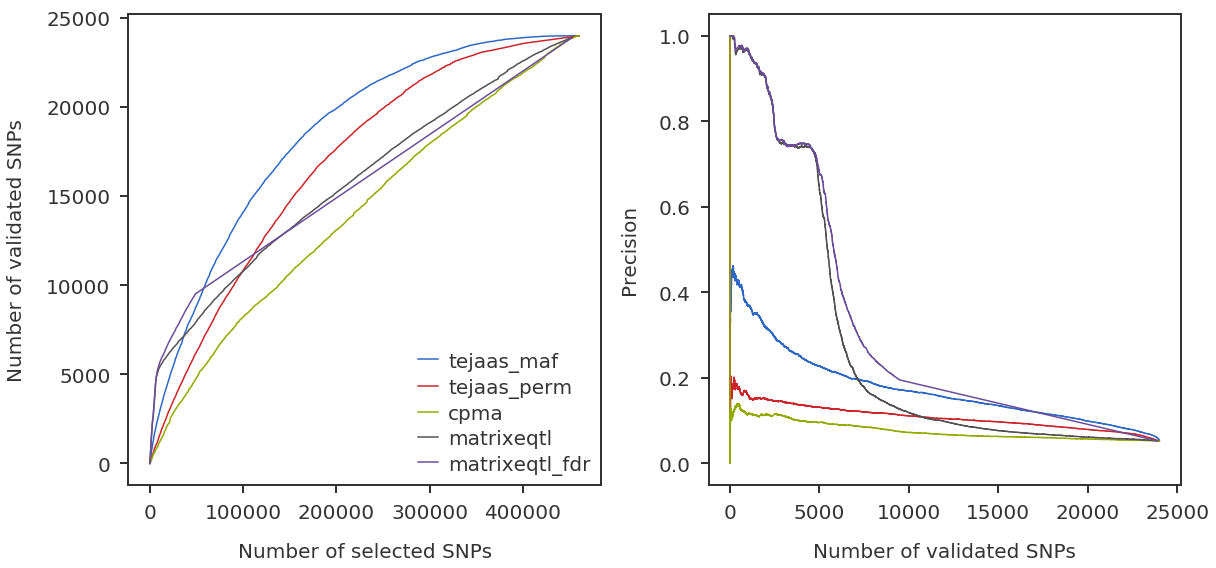

In [16]:
outfile = '../plots/gtex_ms_hlv_lmcorrected_validation_tejaas-sb0_01.pdf'
fig = plt.figure(figsize = (17, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

plot_methods = ['tejaas_maf', 'tejaas_perm', 'cpma', 'matrixeqtl', 'matrixeqtl_fdr']
#plot_methods = ['tejaas_maf']

for key in plot_methods:
    valid, select, ppv = roc.confusion_matrix(valres[key])
    ax1.plot(select, valid, label = key)
    ax2.plot(valid, ppv, label = key)

ylabel = r'Precision'
ax2.set_ylabel(ylabel)
ylabel = r'Number of validated SNPs'
ax1.set_ylabel(ylabel)
xlabel = r'Number of validated SNPs'
ax2.set_xlabel(xlabel)
xlabel = r'Number of selected SNPs'
ax1.set_xlabel(xlabel)
#ax1.set_xlim([0, 10000])
#ax1.set_ylim([0, 5000])
ax1.legend()
plt.tight_layout()
plt.savefig(outfile, bbox_inches='tight')
plt.show()

In [ ]:
len(res['matrixeqtl_rand']['crossval'])

In [ ]:
len(res['tejaas_maf']['test'])

In [ ]:
valid

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(select, valid)
plt.xlim([0, 50000])
plt.show()

In [ ]:
with open('dump_meqtl_res.txt', 'w') as wfile:
    for x in valres[key]:
        wfile.write("{:s}\t{:g}\t{:d}\n".format(x.rsid, x.stat, x.causality))